# Utils

In [3]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [4]:
def yolo_to_bbox(gcls, yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)

    return [gcls, x_min, y_min, x_max, y_max]

In [6]:
import numpy as np

def average_precision(recalls, precisions):
    """
    한 클래스에 대한 Average Precision (AP) 계산.

    매개변수:
        recalls: recall 값들의 리스트
        precisions: precision 값들의 리스트

    반환값:
        AP: float 값
    """
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

def mean_average_precision(predictions, ground_truths, iou_threshold=0.5):
    """
    물체 검출을 위한 Mean Average Precision (mAP) 계산.

    매개변수:
        predictions: 예측 박스들의 리스트, 형식 [class_id, confidence, x1, y1, x2, y2]
        ground_truths: 정답 박스들의 리스트, 형식 [class_id, x1, y1, x2, y2]
        iou_threshold: float 값, IoU 임계값으로 이 값 이상일 때 True Positive로 간주

    반환값:
        mAP: float 값
    """
    class_ids = list(set([box[0] for boxes in ground_truths for box in boxes]))
    average_precisions = []

    for class_id in class_ids:
        class_predictions = [box for boxes in predictions for box in boxes if box[0] == class_id]
        class_ground_truths = [box for boxes in ground_truths for box in boxes if box[0] == class_id]

        if len(class_ground_truths) == 0:
            continue

        class_predictions = sorted(class_predictions, key=lambda x: x[1], reverse=True)

        tp = np.zeros(len(class_predictions))
        fp = np.zeros(len(class_predictions))

        matched_gt_boxes = []

        for i, pred_box in enumerate(class_predictions):
            best_iou = 0
            best_gt_box = None

            for gt_box in class_ground_truths:
                if gt_box in matched_gt_boxes:
                    continue

                iou = IoU(pred_box[2:], gt_box[1:])

                if iou > best_iou:
                    best_iou = iou
                    best_gt_box = gt_box

            if best_iou >= iou_threshold and best_gt_box is not None:
                tp[i] = 1
                matched_gt_boxes.append(best_gt_box)
            else:
                fp[i] = 1

        fp_cumsum = np.cumsum(fp)
        tp_cumsum = np.cumsum(tp)
        recalls = tp_cumsum / len(class_ground_truths)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        ap = average_precision(recalls, precisions)
        average_precisions.append(ap)

    mAP = np.mean(average_precisions) if len(average_precisions) > 0 else 0.0
    return mAP


In [7]:
import os
import cv2

def get_score_map(model, root_folder, image_folder, evc):
    """
    Parameters: 
        model: input model trained with ultralytics
        root_folder: labels folder location
        image_folder: image folder loacation
        evc: evaluation count which means the number of images want to use for evalution
    
    Normailized mAP score has not implemented but I think it is not necessary
    """
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
    predictions, ground_truths = [], []
    iou_threshold = 0.5

    map_score = 0
    map_score_normalize = 0
    count = 0
    
    for image_file in image_files:
        if count == evc:
            break
        image = cv2.imread(image_folder + image_file)
        height, width, _ = image.shape
        results = model.predict(image_folder + image_file, device='mps', verbose=False)
        box_pred = []
        for result in results[0]:
            li = [float(result.boxes.cls), float(result.boxes.conf)]
            for xy in result.boxes.xyxy[0]:
                li.append(float(xy))
            box_pred.append(li)

        box_gt = []
        label_file = image_file[:-3] + "txt"
        with open(root_folder + label_file) as f:
            for l in f:
                parts = l.strip().split()
                gcls, xc, yc, w, h = map(float, parts)
                conv_coor = yolo_to_bbox(gcls, [xc, yc, w, h], float(width), float(height))
                box_gt.append(conv_coor)
        predictions.append(box_pred)
        ground_truths.append(box_gt)

        count += 1
    map_score += mean_average_precision(predictions=predictions, ground_truths=ground_truths, iou_threshold=iou_threshold)
    print("mAP score: " + str(map_score))

    return map_score, map_score_normalize

In [12]:
import os

def get_score_conf(model, image_folder, evc):
    """
    Parameters: 
        model: input model trained with ultralytics
        root_folder: labels folder location
        image_folder: image folder loacation
        evc: evaluation count which means the number of images want to use for evalution
    
    Normailized mAP score has not implemented but I think it is not necessary
    """
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]

    conf_score = 0
    count = 0
    
    for image_file in image_files:
        if count == evc:
            break
        results = model.predict(image_folder + image_file, device='mps', verbose=False)
        for result in results[0]:
            conf_score += float(sum(result.boxes.conf))

        count += 1
    print("conf score: " + str(conf_score))

    return conf_score

conf score: 29.69745045900345


29.69745045900345

In [13]:
from ultralytics import YOLO

def get_best_conf(image_folder, evc):
    models = [
        'model/YOLOv8-large-daytime/weights/best.pt',
        'model/YOLOv8-large-daytime-blur/weights/best.pt',
        'model/YOLOv8-large-daytime-brightness-v2/weights/best.pt',
        'model/YOLOv8-large-daytime-cond&ice/weights/best.pt',
        'model/YOLOv8-large-daytime-gaussian/weights/best.pt',
        'model/YOLOv8-large-daytime-rain/weights/best.pt',
        'model/YOLOv8-large-night-blur/weights/best.pt',
        'model/YOLOv8-large-night-brightness/weights/best.pt',
        'model/YOLOv8-large-night-cond&ice/weights/best.pt',
        'model/YOLOv8-large-night-gaussian/weights/best.pt',
        'model/YOLOv8-large-night-original/weights/best.pt',
        'model/YOLOv8-large-night-rain/weights/best.pt'
    ]
    max = 0
    best_model = ''
    for model in models:
        score = get_score_conf(model=YOLO(model), image_folder=image_folder, evc=evc)
        if max <= score:
            max = score
            best_model = model
    return best_model

conf score: 44.40493279695511
conf score: 49.41900706291199
conf score: 45.58140605688095
conf score: 45.67692905664444
conf score: 0.35209929943084717
conf score: 46.37084338068962
conf score: 43.508563578128815
conf score: 39.885797798633575
conf score: 36.4433408677578
conf score: 35.287349700927734
conf score: 39.732000440359116
conf score: 38.90232917666435


'model/YOLOv8-large-daytime-blur/weights/best.pt'

# Scenario 1

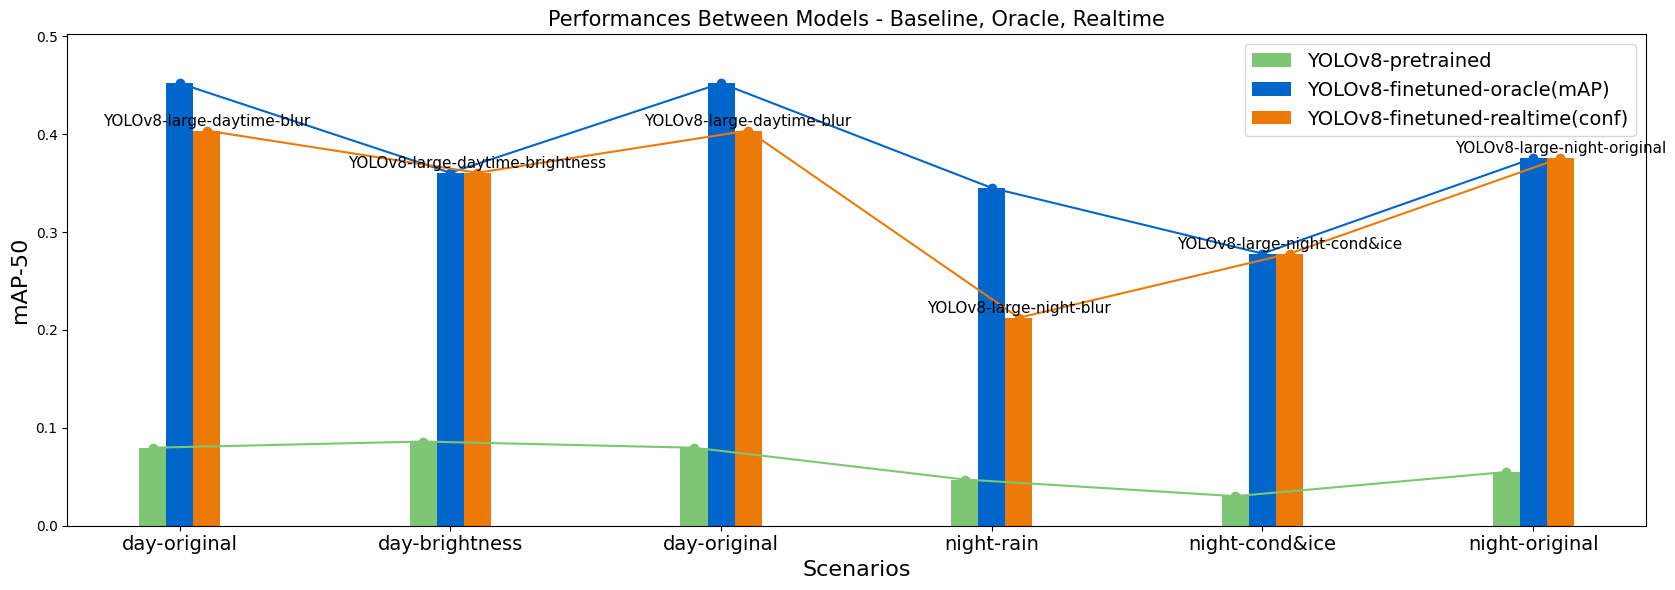

In [39]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    No noise(d)
    Brightness(d)
    No noise(d)
    Rain(n)
    Cond&ice(n)
    No noise(n)
'''
image_folders = [
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-brightness/images/test/',
    'BDD100k-daytime/images/test/',
    'BDD100k-rain/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k/images/test/'
]

label_folders = [
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-brightness/labels/test/',
    'BDD100k-daytime/labels/test/',
    'BDD100k-rain/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k/labels/test/'
]

categories_c1 = [
    'day-original',
    'day-brightness',
    'day-original',
    'night-rain',
    'night-cond&ice',
    'night-original'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime-brightness-v2/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-original/weights/best.pt')

baseline_c1 = []
oracle_c1 = []
realtime_c1 = []

EVC = 300

for i in range(len(image_folders)):
    baseline_c1.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=EVC)[0])

oracle_c1.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=EVC)[0])
oracle_c1.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=EVC)[0])
oracle_c1.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=EVC)[0])
oracle_c1.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=EVC)[0])
oracle_c1.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=EVC)[0])
oracle_c1.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=EVC)[0])

best_models_conf = []
for i in range(len(image_folders)):
    best_model_conf = get_best_conf(image_folder=image_folders[i], evc=EVC*0.05)
    best_models_conf.append(best_model_conf)
    realtime_c1.append(get_score_map(model=YOLO(best_model_conf), root_folder=label_folders[i], image_folder=image_folders[i], evc=EVC)[0])

categories_c1 = [
    'day-original',
    'day-brightness',
    'day-original',
    'night-rain',
    'night-cond&ice',
    'night-original'
]

x = np.arange(len(categories_c1))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 1*width, baseline_c1, width, label='YOLOv8-pretrained', color='#7CC674')
ax.plot(x - 1*width, baseline_c1, marker='o', color='#7CC674')

ax.bar(x, oracle_c1, width, label='YOLOv8-finetuned-oracle(mAP)', color='#06C')
ax.plot(x, oracle_c1, marker='o', color='#06C')

ax.bar(x + 1*width, realtime_c1, width, label='YOLOv8-finetuned-realtime(conf)', color='#EC7A08')
ax.plot(x + 1*width, realtime_c1, marker='o', color='#EC7A08')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories_c1, fontsize=14)
ax.legend(fontsize=14)

y_min = 0
y_max = max([max(baseline_c1), max(oracle_c1), max(realtime_c1)]) + 0.05
ax.set_ylim([y_min, y_max])

for i in range(len(categories_c1)): 
    ax.text(x[i] + 1*width, realtime_c1[i] + 0.005, f'{best_models_conf_c1[i]}', ha='center', fontsize=11, color='#000')

fig.tight_layout()

plt.show()

In [22]:
print(baseline_c1)
print(oracle_c1)
print(realtime_c1)
best_models_conf_c1 = ['YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-brightness', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-night-blur', 'YOLOv8-large-night-cond&ice', 'YOLOv8-large-night-original']
print(best_models_conf_c1)

[0.07968843566121994, 0.08602164964697141, 0.07968843566121994, 0.04722091226986083, 0.030205319371332515, 0.054856560777086706]
[0.4520686637552829, 0.3606210095498326, 0.4520686637552829, 0.34512223190539876, 0.2780402626867886, 0.3754786701832615]
[0.4036726265478321, 0.3606210095498326, 0.4036726265478321, 0.21249565738180864, 0.2780402626867886, 0.3754786701832615]
['YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-brightness', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-night-blur', 'YOLOv8-large-night-cond&ice', 'YOLOv8-large-night-original']


# Scenario 2

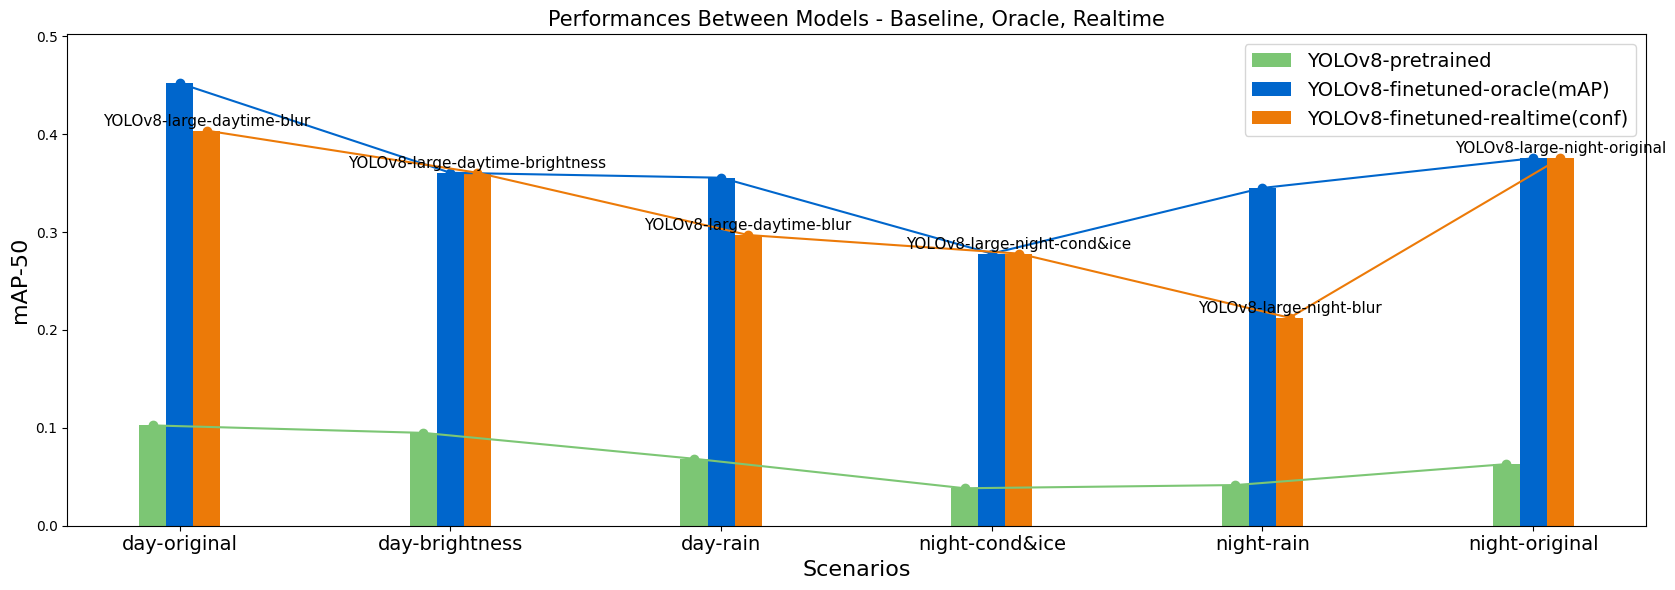

In [41]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    No noise(d)
    Brightness(d)
    Rain(d)
    Cond&ice(n)
    Rain(n)
    No noise(n)
'''
image_folders = [
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-brightness/images/test/',
    'BDD100k-daytime-rain/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k-rain/images/test/',
    'BDD100k/images/test/'
]

label_folders = [
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-brightness/labels/test/',
    'BDD100k-daytime-rain/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k-rain/labels/test/',
    'BDD100k/labels/test/'
]

categories_c2 = [
    'day-original',
    'day-brightness',
    'day-rain',
    'night-cond&ice',
    'night-rain',
    'night-original'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime-brightness-v2/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime-rain/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-original/weights/best.pt')

baseline_c2 = []
oracle_c2 = []
realtime_c2 = []

EVC = 300

for i in range(len(image_folders)):
    baseline_c2.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=100)[0])

oracle_c2.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=EVC)[0])
oracle_c2.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=EVC)[0])
oracle_c2.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=EVC)[0])
oracle_c2.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=EVC)[0])
oracle_c2.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=EVC)[0])
oracle_c2.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=EVC)[0])

best_models_conf = []
for i in range(len(image_folders)):
    best_model_conf = get_best_conf(image_folder=image_folders[i], evc=EVC*0.05)
    best_models_conf.append(best_model_conf.split('/')[1])
    realtime_c2.append(get_score_map(model=YOLO(best_model_conf), root_folder=label_folders[i], image_folder=image_folders[i], evc=EVC)[0])

x = np.arange(len(categories_c2))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 1*width, baseline_c2, width, label='YOLOv8-pretrained', color='#7CC674')
ax.plot(x - 1*width, baseline_c2, marker='o', color='#7CC674')

ax.bar(x, oracle_c2, width, label='YOLOv8-finetuned-oracle(mAP)', color='#06C')
ax.plot(x, oracle_c2, marker='o', color='#06C')

ax.bar(x + 1*width, realtime_c2, width, label='YOLOv8-finetuned-realtime(conf)', color='#EC7A08')
ax.plot(x + 1*width, realtime_c2, marker='o', color='#EC7A08')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories_c2, fontsize=14)
ax.legend(fontsize=14)

y_min = 0
y_max = max([max(baseline_c2), max(oracle_c2), max(realtime_c2)]) + 0.05
ax.set_ylim([y_min, y_max])

for i in range(len(categories_c2)): 
    ax.text(x[i] + 1*width, realtime_c2[i] + 0.005, f'{best_models_conf_c2[i]}', ha='center', fontsize=11, color='#000')

fig.tight_layout()

plt.show()

In [23]:
print(baseline_c2)
print(oracle_c2)
print(realtime_c2)
best_models_conf_c2 = ['YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-brightness', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-night-cond&ice', 'YOLOv8-large-night-blur', 'YOLOv8-large-night-original']
print(best_models_conf_c2)

[0.10249831911062472, 0.09487236921773258, 0.06844028763527747, 0.03827506366459367, 0.04154795417996869, 0.06292024806982757]
[0.4520686637552829, 0.3606210095498326, 0.35557620269306195, 0.2780402626867886, 0.34512223190539876, 0.3754786701832615]
[0.4036726265478321, 0.3606210095498326, 0.2970147745471523, 0.2780402626867886, 0.21249565738180864, 0.3754786701832615]
['YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-brightness', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-night-cond&ice', 'YOLOv8-large-night-blur', 'YOLOv8-large-night-original']


# Scenario 3

mAP score: 0.06982818319420227
mAP score normalized: 0
mAP score: 0.07968843566121994
mAP score normalized: 0
mAP score: 0.06085015937912863
mAP score normalized: 0
mAP score: 0.04866730012744449
mAP score normalized: 0
mAP score: 0.030205319371332515
mAP score normalized: 0
mAP score: 0.04722091226986083
mAP score normalized: 0
mAP score: 0.3999380389410001
mAP score normalized: 0
mAP score: 0.4520686637552829
mAP score normalized: 0
mAP score: 0.35557620269306195
mAP score normalized: 0
mAP score: 0.36757950187095473
mAP score normalized: 0
mAP score: 0.2780402626867886
mAP score normalized: 0
mAP score: 0.34512223190539876
mAP score normalized: 0
conf score: 134.27988123893738
conf score: 153.23092076182365
conf score: 125.27381229400635
conf score: 138.08349040150642
conf score: 0.35209929943084717
conf score: 137.68476939201355
conf score: 124.39926201105118
conf score: 102.8078024983406
conf score: 103.19397562742233
conf score: 105.12500047683716
conf score: 107.386100679636
con

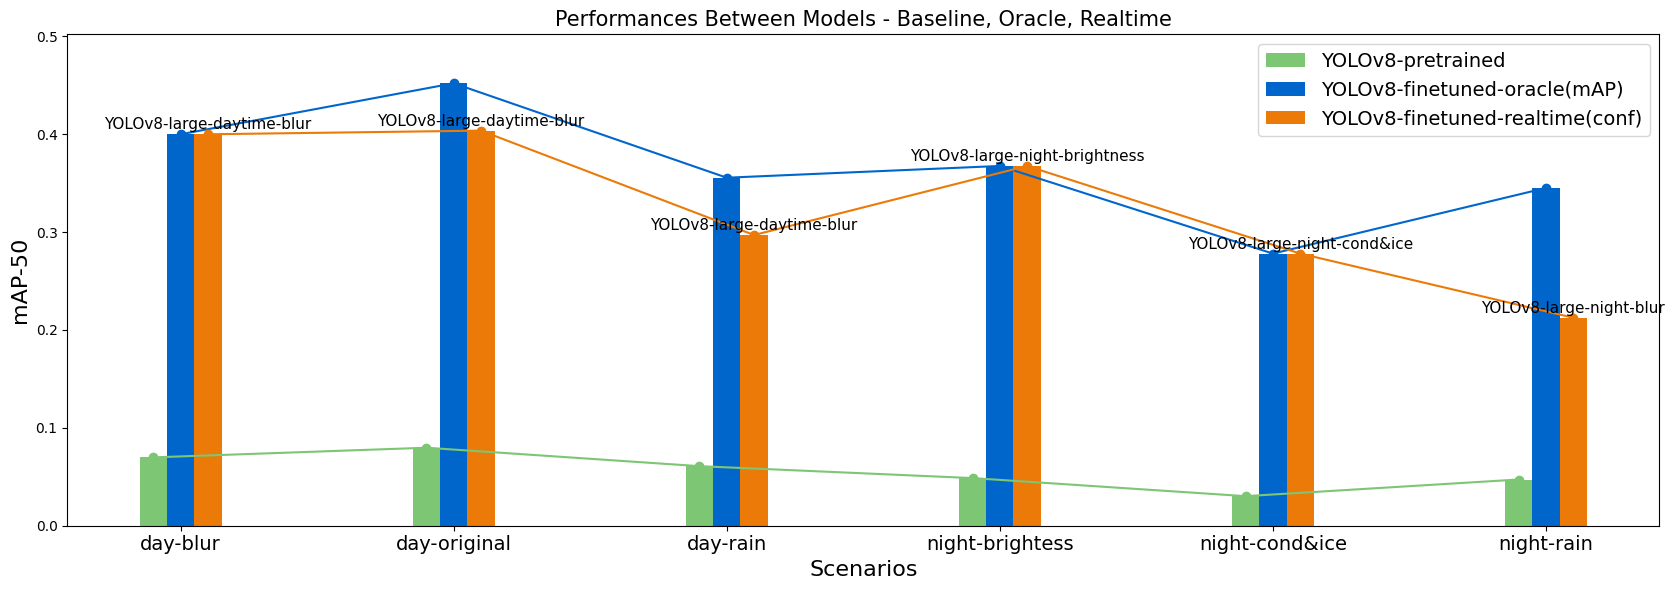

In [48]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    Blur(d)
    No noise(d)
    Rain(d)
    Brightness(n)
    Cond&ice(n)
    Rain(n)
'''
image_folders = [
    'BDD100k-daytime-blur/images/test/',
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-rain/images/test/',
    'BDD100k-brightness/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k-rain/images/test/'
]

label_folders = [
    'BDD100k-daytime-blur/labels/test/',
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-rain/labels/test/',
    'BDD100k-brightness/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k-rain/labels/test/'
]

categories_c3 = [
    'day-blur',
    'day-original',
    'day-rain',
    'night-brightess',
    'night-cond&ice',
    'night-rain'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime-blur/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime-rain/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-brightness/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')

baseline_c3 = []
oracle_c3 = []
realtime_c3 = []

EVC = 300

for i in range(len(image_folders)):
    baseline_c3.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=EVC)[0])

oracle_c3.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=EVC)[0])
oracle_c3.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=EVC)[0])
oracle_c3.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=EVC)[0])
oracle_c3.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=EVC)[0])
oracle_c3.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=EVC)[0])
oracle_c3.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=EVC)[0])

best_models_conf_c3 = []
for i in range(len(image_folders)):
    best_model_conf = get_best_conf(image_folder=image_folders[i], evc=EVC*0.05)
    best_models_conf_c3.append(best_model_conf.split('/')[1])
    realtime_c3.append(get_score_map(model=YOLO(best_model_conf), root_folder=label_folders[i], image_folder=image_folders[i], evc=EVC)[0])

x = np.arange(len(categories_c2))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 1*width, baseline_c3, width, label='YOLOv8-pretrained', color='#7CC674')
ax.plot(x - 1*width, baseline_c3, marker='o', color='#7CC674')

ax.bar(x, oracle_c3, width, label='YOLOv8-finetuned-oracle(mAP)', color='#06C')
ax.plot(x, oracle_c3, marker='o', color='#06C')

ax.bar(x + 1*width, realtime_c3, width, label='YOLOv8-finetuned-realtime(conf)', color='#EC7A08')
ax.plot(x + 1*width, realtime_c3, marker='o', color='#EC7A08')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories_c3, fontsize=14)
ax.legend(fontsize=14)

y_min = 0
y_max = max([max(baseline_c3), max(oracle_c3), max(realtime_c3)]) + 0.05
ax.set_ylim([y_min, y_max])

for i in range(len(categories_c3)): 
    ax.text(x[i] + 1*width, realtime_c3[i] + 0.005, f'{best_models_conf_c3[i]}', ha='center', fontsize=11, color='#000')

fig.tight_layout()

plt.show()

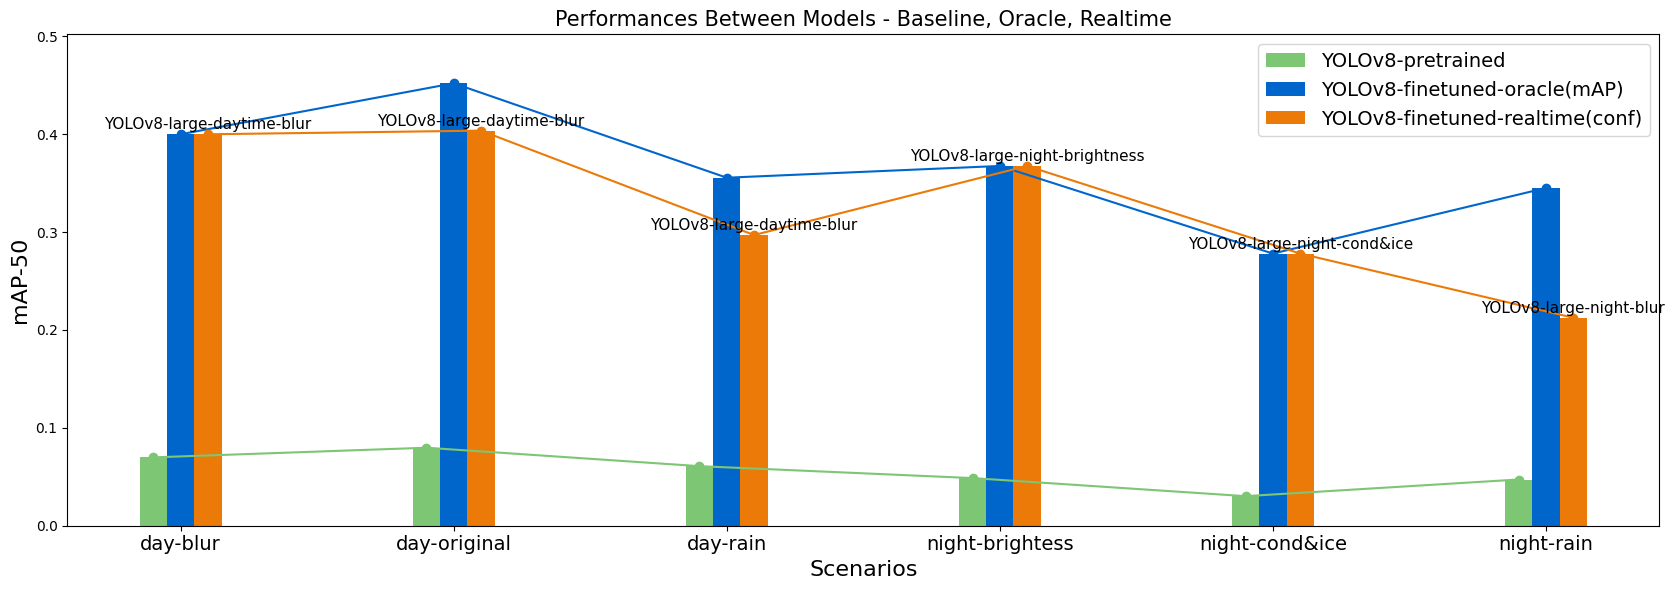

In [49]:
x = np.arange(len(categories_c2))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 1*width, baseline_c3, width, label='YOLOv8-pretrained', color='#7CC674')
ax.plot(x - 1*width, baseline_c3, marker='o', color='#7CC674')

ax.bar(x, oracle_c3, width, label='YOLOv8-finetuned-oracle(mAP)', color='#06C')
ax.plot(x, oracle_c3, marker='o', color='#06C')

ax.bar(x + 1*width, realtime_c3, width, label='YOLOv8-finetuned-realtime(conf)', color='#EC7A08')
ax.plot(x + 1*width, realtime_c3, marker='o', color='#EC7A08')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories_c3, fontsize=14)
ax.legend(fontsize=14)

y_min = 0
y_max = max([max(baseline_c3), max(oracle_c3), max(realtime_c3)]) + 0.05
ax.set_ylim([y_min, y_max])

for i in range(len(categories_c3)): 
    ax.text(x[i] + 1*width, realtime_c3[i] + 0.005, f'{best_models_conf_c3[i]}', ha='center', fontsize=11, color='#000')

fig.tight_layout()

plt.show()

In [50]:
print(baseline_c3)
print(oracle_c3)
print(realtime_c3)
print(best_models_conf_c3)

[0.06982818319420227, 0.07968843566121994, 0.06085015937912863, 0.04866730012744449, 0.030205319371332515, 0.04722091226986083]
[0.3999380389410001, 0.4520686637552829, 0.35557620269306195, 0.36757950187095473, 0.2780402626867886, 0.34512223190539876]
[0.3999380389410001, 0.4036726265478321, 0.2970147745471523, 0.36757950187095473, 0.2780402626867886, 0.21249565738180864]
['YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-daytime-blur', 'YOLOv8-large-night-brightness', 'YOLOv8-large-night-cond&ice', 'YOLOv8-large-night-blur']
